In [1]:
#Imports


#Format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Manage data
import pandas as pd
import pickle

##Scraper
#Handle urls
from urllib.parse import quote
#Create waits
import numpy as np
#Scrape
import os, time, re
import bs4 as bs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

## Plot
import seaborn as sns
%matplotlib inline

### Table of contents
- 1. [Data](#data)
    - 1.1 ISO2
    - 1.2 Titles to scrape
- 2. [Scraper](#scraper)

<a id='data'></a>
## 1 Data


### 1.1 ISO2 (country codes)

In [2]:
# # Get and save the iso2 codes (do it only once)
# df = pd.read_html("https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2",header=0,na_values=[""],keep_default_na=False)[2]
# df["Code"] = df["Code"].str.lower()
# code2country = df.set_index("Code").to_dict()["Country name"]
# code2country["ko"] = "Kosovo"
# code2country["an"] = "Netherlands Antilles"

# pickle.dump(code2country,open("./data/code2country.dump","wb+"))

In [3]:
code2country = pickle.load(open("data/code2country.dump","rb"))

### 1.2 Titles to scrape

In [4]:
titles = ["Tax","Transfer pricing","Wealth management","Wealth manager","International tax","wealth advisor","Tax partner","Tax advisor","Tax director","Tax manager",
          "Tax risk management","Tax counsel","tax consultant","tax analyst","tax planning","tax lawyer","TP advisor","TP director","TP manager","TP risk management",
          "TP counsel","TP consultant","TP analyst","TP consultant","TP partner","Lawyer","Engineer","Doctor","Teacher","Manager","physician","IT Specialist",
         "management consultant", "auditor","accountant"]



In [5]:
not_existing_countries = ['cc', 'pm', 'mf', 'sx', 'bq', 'um', 'tk', 'kp', 'bl', 'bv', 'hm', 'sj','gs', 'cx', 'cw']
for country in not_existing_countries:
    del code2country[country]

<a id='scraper'></a>
## 2 Scraper


37.300242130750604 3.11899981807 1


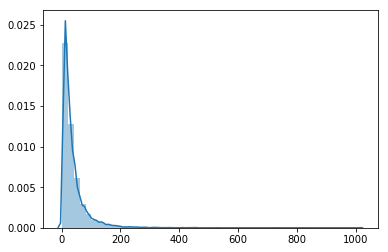

In [6]:
#Time to wait to finish in one week
av_wait = 3600*24*5/(len(code2country)*len(titles)) - 15 #15 seconds to load the page
sigma = 1
mu = np.log(av_wait) - sigma**2/2

import seaborn as sns
%matplotlib inline
sns.distplot(np.random.lognormal(mu,sigma=sigma,size=10000))
print(av_wait,mu,sigma)

#Random waits (lognormally distributed)
def wait(): 
    time.sleep(np.random.lognormal(mu,sigma=sigma))

In [7]:
def login(driver):
    driver.get('https://www.linkedin.com')
    get_by_xpath(driver, '//*[@class="login-email"]').send_keys(os.environ['LINKEDIN_USERNAME'])
    get_by_xpath(driver, '//*[@class="login-password"]').send_keys(os.environ['LINKEDIN_PASSWORD'])
    get_by_xpath(driver, '//*[@id="login-submit"]').click()
    time.sleep(5)
    
def get_by_xpath(driver, xpath, wait_timeout=5):
    return WebDriverWait(driver, wait_timeout).until(EC.presence_of_element_located((By.XPATH, xpath)))

#Create the link to scrape
def create_link(country,title):
    return "https://www.linkedin.com/search/results/people/?facetGeoRegion=[%22{0}%3A0%22]&keywords={1}".format(country,quote(title))

#Get new page
def fetch_new_country(driver,country,title):
    driver.get(create_link(country,title))
    html = bs.BeautifulSoup(driver.page_source,"html.parser")
    try: 
        x = html.find_all('h3',{"class":"search-s-facet__name Sans-17px-black-55%-semibold"})[-1].text
    except:
        x = ""
    if x == "1st":
        raise ValueError("Oh oh time to make a new account")
        
    if "Your search returned no results. Try removing filters or rephrasing your search." in driver.page_source:
        return "0"

        
    results = html.find("h3",{"class":re.compile("search-results.*")}).text
    return "".join(re.findall(r'\d+', results))
    

In [8]:
def scrape():
    driver = webdriver.Firefox(executable_path="./geckodriver") # webdriver.PhantomJS(service_args=['--ignore-ssl-errors=true']).
    login(driver)

    df = pd.read_csv("data/linkedin_results.csv",sep="\t",header=None)
    studied = set(df[2] + df[0])

    count = 0
    with open("data/linkedin_results.csv","a+") as f:
        for title in titles:
            print()
            print("-"*100)
            print(title)
            for country in code2country:
                if title+country in studied:
                    continue
                print(country, end=":::")
                count += 1
                try:
                    r = fetch_new_country(driver,country,title)
                    f.write("{}\t{}\t{}\t{}\n".format(country,code2country[country],title,r))
                except ValueError:
                    print("\nBlocked")
                    driver.quit()
                    return 1
                except Exception as e:
                    print(e)
                    print("\nFAILED COUNTRY")
                wait()
 
    driver.quit()
    if count == 0:
        return 0
    else:
        return 1

In [9]:
list_users = []
with open(".keys") as f:
    for line in f:
        email,pwd = line.strip().split()
        list_users.append((email,pwd))

i = 0
flag = 1
while flag and (len(list_users)>0):
    print("new credentials")
    
    credentials = list_users[i]
    i += 1
    i = i%len(list_users)
    
    os.environ["LINKEDIN_USERNAME"] = credentials[0]
    os.environ["LINKEDIN_PASSWORD"] = credentials[1]

    flag = scrape()
    
    #Here pop if the account get blocked


new credentials
mesiaca@gmail.com

----------------------------------------------------------------------------------------------------
Tax

----------------------------------------------------------------------------------------------------
Transfer pricing

----------------------------------------------------------------------------------------------------
Wealth management

----------------------------------------------------------------------------------------------------
Wealth manager

----------------------------------------------------------------------------------------------------
International tax

----------------------------------------------------------------------------------------------------
wealth advisor

----------------------------------------------------------------------------------------------------
Tax partner

----------------------------------------------------------------------------------------------------
Tax advisor

--------------------------------------